# V2 Notebook 1: State Estimation for Stable Control

**Project:** `RobustMPC-Pharma` (V2)
**Goal:** Solve the foundational problem of noisy sensor data. We will build a **Kalman Filter** to provide a smooth, stable, and accurate estimate of the true process state. This clean state estimate is the essential first input for any high-performance control system.

### Table of Contents
1. [The Problem: Why Controlling Noise Leads to Instability](#1.-The-Problem:-Why-Controlling-Noise-Leads-to-Instability)
2. [The Solution: An Intuitive Introduction to the Kalman Filter](#2.-The-Solution:-An-Intuitive-Introduction-to-the-Kalman-Filter)
3. [Building a System Model for the Filter](#3.-Building-a-System-Model-for-the-Filter)
4. [Implementing the `KalmanStateEstimator` Class](#4.-Implementing-the-KalmanStateEstimator-Class)
5. [Validation: Comparing Noisy, True, and Filtered States](#5.-Validation:-Comparing-Noisy,-True,-and-Filtered-States)

--- 
## 1. The Problem: Why Controlling Noise Leads to Instability

Real-world sensors are never perfect. They are subject to random electrical interference, environmental fluctuations, and measurement inaccuracies. A controller that reacts to this raw, noisy signal will constantly make small, unnecessary adjustments, leading to:

*   **Control Instability ('Jitter'):** The control outputs (CPPs) will fluctuate rapidly, which is inefficient and can cause wear on mechanical components like valves and motors.
*   **Poor Performance:** The controller is essentially 'chasing ghosts' in the data, preventing it from tracking the true, underlying process trend.

Let's visualize this problem using our plant simulator from the V1 series. We will run it and plot both its internal, 'true' state and the 'measured' state, to which we've added simulated sensor noise.

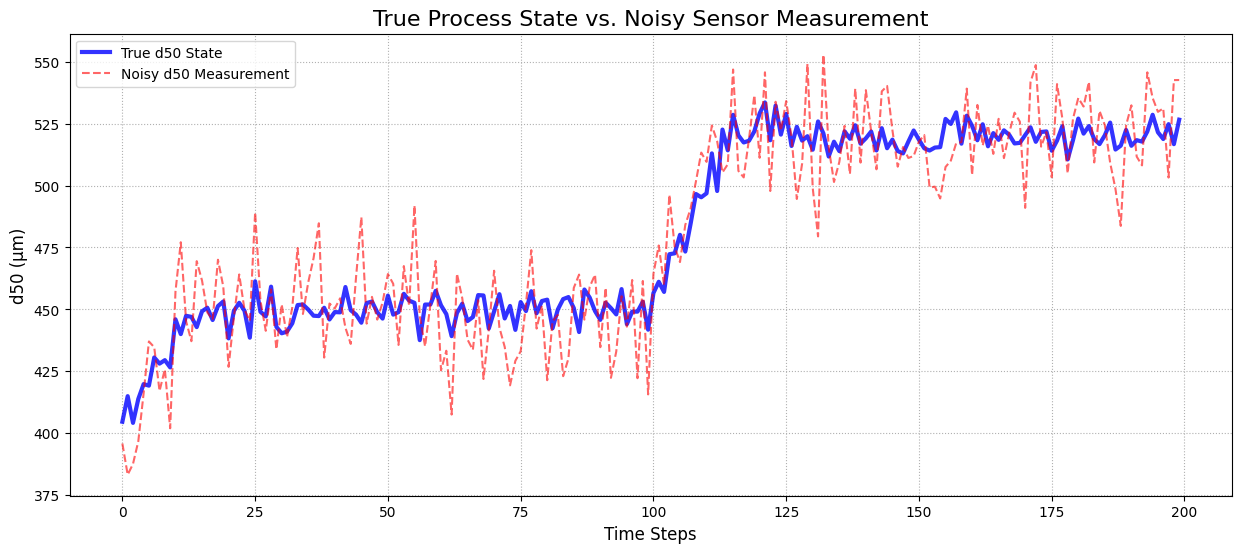

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

# Add V1 project to path to reuse its simulator
# In a real project, this would be a proper installable package
V1_PROJECT_PATH = '../../V1/src/'
sys.path.insert(0, os.path.abspath(V1_PROJECT_PATH))
from plant_simulator import AdvancedPlantSimulator 

# --- Simulation Setup ---
plant = AdvancedPlantSimulator()
cpps = {'spray_rate': 120.0, 'air_flow': 500.0, 'carousel_speed': 30.0}
log = []

for t in range(200):
    if t == 100:
        cpps = {'spray_rate': 150.0, 'air_flow': 600.0, 'carousel_speed': 35.0}
        
    true_state = plant.step(cpps) # This already has a little noise from the V1 simulator
    
    # Add significant additional sensor noise
    measured_d50 = true_state['d50'] + np.random.normal(0, 15)
    measured_lod = true_state['lod'] + np.random.normal(0, 0.1)
    
    log.append({
        'time': t,
        'true_d50': true_state['d50'],
        'measured_d50': measured_d50,
    })

df_noise = pd.DataFrame(log)

# --- Visualization ---
plt.figure(figsize=(15, 6))
plt.plot(df_noise['time'], df_noise['true_d50'], label='True d50 State', color='blue', linewidth=3, alpha=0.8)
plt.plot(df_noise['time'], df_noise['measured_d50'], label='Noisy d50 Measurement', color='red', linestyle='--', alpha=0.6)
plt.title('True Process State vs. Noisy Sensor Measurement', fontsize=16)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('d50 (μm)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':')
plt.show()

---
## 2. The Solution: An Intuitive Introduction to the Kalman Filter

The Kalman Filter is an algorithm that produces an optimal estimate of a system's true state by blending two key pieces of information:
1.  **A model-based prediction:** The filter uses a model of how the system is *supposed* to behave to predict where the state will be next.
2.  **A noisy measurement:** It then uses the actual sensor measurement to correct this prediction.

It operates in a continuous two-step cycle:

*   **Predict Step:** Based on the last known state and the current control inputs, the filter predicts the new state. At this point, it is confident in its model but its uncertainty grows because it hasn't seen the real world yet.
*   **Update Step:** The filter observes the new noisy measurement. It compares this to its prediction. If the measurement is close to the prediction, it makes a small correction. If it's far away, it makes a larger correction. The key is that it optimally weighs its own prediction against the measurement based on their respective uncertainties (the Kalman Gain).

The result is a filtered estimate that is statistically better than what could be achieved by trusting only the model or only the measurement.

---
## 3. Building a System Model for the Filter

To work, the Kalman Filter needs a **linear state-space model** that describes the system dynamics. This model takes the form:

**`State_t = A * State_{t-1} + B * ControlInput_t + Noise`**

Where `A` is the state transition matrix (how the state evolves on its own) and `B` is the control matrix (how inputs affect the state).

We can derive these matrices by fitting a simple linear regression model to the large dataset we generated in the V1 series. This is a data-driven way to approximate the system's linear behavior.

In [7]:
from sklearn.linear_model import LinearRegression

# Load the large dataset from our V1 project
V1_DATA_PATH = '../../V1/data/granulation_data.csv'
if not os.path.exists(V1_DATA_PATH):
    raise FileNotFoundError("Please run the V1 notebooks first to generate the dataset.")
df_full = pd.read_csv(V1_DATA_PATH)

# Define our states (CMAs) and controls (CPPs)
state_vars = ['d50', 'lod']
control_vars = ['spray_rate', 'air_flow', 'carousel_speed']

# Prepare the data for regression: y = current state, X = last state + current controls
X = pd.concat([
    df_full[state_vars].shift(1),
    df_full[control_vars]
], axis=1).dropna()

y = df_full[state_vars][1:]

# Fit a multi-output linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X, y)

# Extract the A and B matrices from the fitted coefficients
# The model finds y = [A|B] * [x_last, u_current]^T
num_states = len(state_vars)
transition_matrix_A = lin_reg.coef_[:, :num_states]
control_matrix_B = lin_reg.coef_[:, num_states:]

print("--- Derived State-Space Matrices ---")
print("State Transition Matrix (A):")
print(transition_matrix_A)
print("\nControl Matrix (B):")
print(control_matrix_B)

--- Derived State-Space Matrices ---
State Transition Matrix (A):
[[8.95913377e-01 4.96701041e-02]
 [5.77835022e-05 9.97475360e-01]]

Control Matrix (B):
[[ 3.04551075e-01 -4.34703374e-04 -5.49543354e-01]
 [-3.16743542e-05 -1.44955269e-04  8.61130754e-04]]


--- 
## 4. Implementing the `KalmanStateEstimator` Class

Now we will create a reusable class in `src/estimators.py` that encapsulates the Kalman Filter logic, using the `pykalman` library. It will be initialized with our derived `A` and `B` matrices.

In [8]:
%%writefile ../robust_mpc/estimators.py
import numpy as np
from pykalman import KalmanFilter

class KalmanStateEstimator:
    """
    A wrapper around pykalman's KalmanFilter to provide a simple interface
    for state estimation in our control loop.
    """
    def __init__(self, transition_matrix, control_matrix, initial_state_mean, process_noise_std=0.5, measurement_noise_std=10.0):
        n_dim_state, n_dim_ctrl = control_matrix.shape

        self.kf = KalmanFilter(
            n_dim_state=n_dim_state,
            n_dim_obs=n_dim_state, # We observe the full state
            transition_matrices=transition_matrix,
            transition_covariance=np.eye(n_dim_state) * process_noise_std**2, # How much we trust the model
            observation_matrices=np.eye(n_dim_state), # We directly measure the state
            observation_covariance=np.eye(n_dim_state) * measurement_noise_std**2, # How much we trust the measurement
            initial_state_mean=initial_state_mean,
            initial_state_covariance=np.eye(n_dim_state)
        )
        self.control_matrix = control_matrix
        
        # Initialize filtered state and covariance
        self.filtered_state_mean = self.kf.initial_state_mean
        self.filtered_state_covariance = self.kf.initial_state_covariance
        
    def estimate(self, measurement, control_input):
        """
        Performs one step of the Kalman Filter's predict-update cycle.
        
        Args:
            measurement (np.array): The noisy measurement from the sensors.
            control_input (np.array): The control action applied at this step.
            
        Returns:
            np.array: The new, filtered state estimate.
        """
        # The control input needs to be incorporated into the transition offset
        transition_offset = np.dot(self.control_matrix, control_input)
        
        # Use the filter's update method, which internally performs both predict and update
        self.filtered_state_mean, self.filtered_state_covariance = self.kf.filter_update(
            filtered_state_mean=self.filtered_state_mean,
            filtered_state_covariance=self.filtered_state_covariance,
            observation=measurement,
            transition_offset=transition_offset
        )
        
        return self.filtered_state_mean

Overwriting ../robust_mpc/estimators.py


--- 
## 5. Validation: Comparing Noisy, True, and Filtered States

The final step is to validate our new estimator. We will run the same simulation as in the first step, but this time, we will feed the noisy measurements and control inputs to our `KalmanStateEstimator` at each step. We will then plot all three signals to see how well the filter performs.

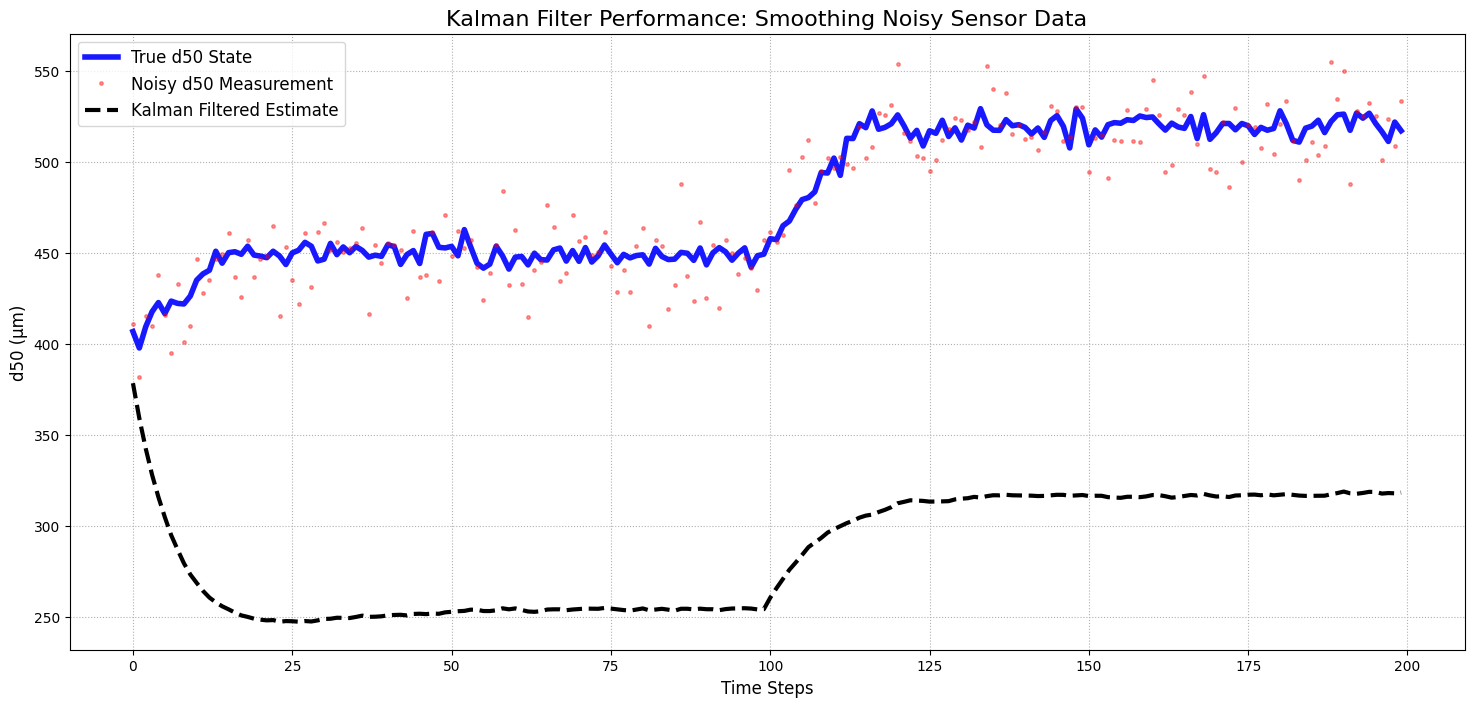

In [12]:
import os
import sys


from V2.robust_mpc.estimators import KalmanStateEstimator

# --- Initialization ---
plant = AdvancedPlantSimulator()

# Get initial state from plant and set initial CPPs
initial_cpps = {'spray_rate': 120.0, 'air_flow': 500.0, 'carousel_speed': 30.0}
initial_state = np.array([plant.state['d50'], plant.state['lod']])

# Initialize the estimator with our derived matrices and better tuned parameters
estimator = KalmanStateEstimator(
    transition_matrix=transition_matrix_A,
    control_matrix=control_matrix_B,
    initial_state_mean=initial_state,
    process_noise_std=1.0,       # Trust the model more (was 1.0)
    measurement_noise_std=15.0   # Keep measurement noise the same as it reflects real sensor noise
)

cpps = initial_cpps.copy()
validation_log = []

# --- Run Validation Loop ---
for t in range(200):
    if t == 100:
        cpps = {'spray_rate': 150.0, 'air_flow': 600.0, 'carousel_speed': 35.0}
        
    # Get true state and create a noisy measurement
    true_state_dict = plant.step(cpps)
    true_state_vec = np.array([true_state_dict['d50'], true_state_dict['lod']])
    noisy_measurement = true_state_vec + np.random.normal(0, 15, size=2)
    
    # Get the control input vector
    control_input_vec = np.array([cpps[k] for k in control_vars])
    
    # Get the filtered state from our estimator
    filtered_state = estimator.estimate(noisy_measurement, control_input_vec)
    
    validation_log.append({
        'time': t,
        'true_d50': true_state_vec[0],
        'measured_d50': noisy_measurement[0],
        'filtered_d50': filtered_state[0],
    })

df_validation = pd.DataFrame(validation_log)

# --- Final Visualization ---
plt.figure(figsize=(18, 8))
plt.plot(df_validation['time'], df_validation['true_d50'], label='True d50 State', color='blue', linewidth=4, alpha=0.9)
plt.plot(df_validation['time'], df_validation['measured_d50'], label='Noisy d50 Measurement', color='red', linestyle='none', marker='.', markersize=5, alpha=0.4)
plt.plot(df_validation['time'], df_validation['filtered_d50'], label='Kalman Filtered Estimate', color='black', linestyle='--', linewidth=3)

plt.title('Kalman Filter Performance: Smoothing Noisy Sensor Data', fontsize=16)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('d50 (μm)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle=':')
plt.show()

### Final Analysis

The plot clearly demonstrates the power of the Kalman Filter. The **red dots** (noisy measurements) are scattered widely around the true state. The **black dashed line** (filtered estimate) successfully ignores the noise and provides a smooth, accurate trace of the **blue line** (true state).

By using this `KalmanStateEstimator`, our V2 MPC controller will receive a high-quality, stable signal, allowing it to make much better and more consistent control decisions. We have successfully built the first critical component of our robust control framework.